# Preparations

## Set up

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## Functions for exploring images

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False,
                                        edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top',
                   color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]    
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Data Transformations

In [7]:
PATH = Path('data/pascal')

trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]: o['name'] for o in trn_j[CATEGORIES]}
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

trn_anno = collections.defaultdict(list)
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

# Largest item classifier

## Data Transformations

In [8]:
def get_lrg(b):
    if not b: raise Exeption()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [9]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                   columns=['fn','cat'])
df.to_csv(CSV, index=False)
#pd.read_csv(CSV).head()

## Define a model

In [10]:
f_model = resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

## Check input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


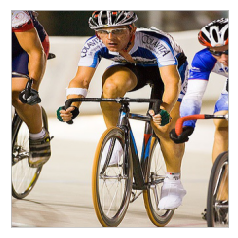

In [13]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

## Train a model

In [ ]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=1)

lrs = np.array([lr/1000,lr/100,lr])
learn.freeze_to(-2)
learn.fit(lrs/5, 1, cycle_len=1)

learn.unfreeze()
learn.fit(lrs/5, 3, cycle_len=2)

In [73]:
learn.load('class_one')

## Check output

In [ ]:
x,y = next(iter(md.val_dl))
print(x.shape); print(y.shape)

In [ ]:
probs = F.softmax(predict_batch(learn.model, x), -1)
print(probs.shape)
print(to_np(probs[:2]))

In [15]:
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)
preds[:3]

array([14, 11,  2, 14, 14,  6, 13,  8,  2, 16])

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

# BBox only

## Data Transformations

In [14]:
BB_CSV = PATH/'tmp/bb.csv'

bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]
df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids], 'bbox': bbs},
                  columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

## Define a model

In [17]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV,
                                  tfms=tfms, continuous=True)

## Check input

In [20]:
x,y=next(iter(md.val_dl))
ima = md.val_ds.denorm(to_np(x))[2]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 132., 206.])

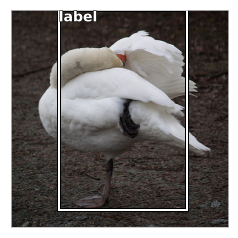

In [21]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

## Add layers on top

In [ ]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [ ]:
learn.summary()

## Train a model

In [ ]:
lr = 2e-3
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])
learn.freeze_to(-2)
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze_to(-3)
learn.fit(lrs, 1, cycle_len=2)

In [ ]:
learn.load('reg4')

## Check output

In [ ]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()